<a href="https://colab.research.google.com/github/Nicordaro/MML/blob/main/MML_Thesis_v2_noSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Mathematics in Machine Learning
#Tesina
Nicolò Cordaro s272145

---



###Organize imports and dataset definition

In [1]:
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shutil
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

scoring = make_scorer(f1_score)

import warnings
warnings.filterwarnings("ignore")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

SEED = 42

def confmat(y_test,pred):
    cf_matrix = confusion_matrix(y_test, pred)
    ax = sns.heatmap(cf_matrix, annot=True,  fmt='g', cmap='coolwarm', xticklabels=["benign","malign"], yticklabels=["benign","malign"]) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set(xlabel='True Label', ylabel='Predicted Label')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
tune = False
viz = True

In [3]:
# Clone github repository with dataset
# deleting if already present(Only for development purposes, colab limitations)
!rm -rf MML
!rm -rf dataset
if not os.path.isdir('./MML'):
  !git clone https://github.com/Nicordaro/MML
    
source_dir = './MML/dataset'
target_dir = './dataset'
    
file_names = os.listdir(source_dir)
os.mkdir(target_dir)
for file_name in file_names:
  print(file_name)
  shutil.move(source_dir+"/"+file_name, target_dir+"/"+file_name)

Cloning into 'MML'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 68 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (68/68), done.
breast-cancer-wisconsin.data
wdbc.data
breast-cancer-wisconsin.names


In [4]:
names = {"sampcode":"Sample code number", 
"clump": "Clump Thickness", 
"uni_size":"Uniformity of Cell Size", 
"uni_shape":"Uniformity of Cell Shape", 
"adhesion":"Marginal Adhesion", 
"epith_size":"Single Epithelial Cell Size", 
"nuclei":"Bare Nuclei", 
"chromatin":"Bland Chromatin", 
"nucleoli":"Normal Nucleoli", 
"mitoses":"Mitoses", 
"class":"Class"}

In [5]:
dataset_DF = pd.read_csv(target_dir+"/breast-cancer-wisconsin.data", names=list(names.keys()))
dataset_DF.iloc[:, 10] = dataset_DF.iloc[:, 10].replace(2, "benign").replace(4, "malign")
dataset_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sampcode    699 non-null    int64 
 1   clump       699 non-null    int64 
 2   uni_size    699 non-null    int64 
 3   uni_shape   699 non-null    int64 
 4   adhesion    699 non-null    int64 
 5   epith_size  699 non-null    int64 
 6   nuclei      699 non-null    object
 7   chromatin   699 non-null    int64 
 8   nucleoli    699 non-null    int64 
 9   mitoses     699 non-null    int64 
 10  class       699 non-null    object
dtypes: int64(9), object(2)
memory usage: 60.2+ KB


# Inspection & Preprocessing

In [6]:
for col in dataset_DF.iloc[:, 1:].columns:
  print("Attribute '"+str(col)+"'\t contains: \t"+str(sorted(dataset_DF[col].unique())))

Attribute 'clump'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'uni_size'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'uni_shape'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'adhesion'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'epith_size'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'nuclei'	 contains: 	['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', '?']
Attribute 'chromatin'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'nucleoli'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'mitoses'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 10]
Attribute 'class'	 contains: 	['benign', 'malign']


In [7]:
# Non-numerical values are present in the Bare-nuclei feature
dataset_DF.isin(['?']).any()

sampcode      False
clump         False
uni_size      False
uni_shape     False
adhesion      False
epith_size    False
nuclei         True
chromatin     False
nucleoli      False
mitoses       False
class         False
dtype: bool

In [8]:
# searching non-numeric ("?") occurrances in the dataset
dataset_DF = dataset_DF.drop(dataset_DF[dataset_DF["nuclei"]=="?"].index)
# conversion to numeric the object column
dataset_DF.iloc[:, 6] = pd.to_numeric(dataset_DF.iloc[:, 6])

In [9]:
for col in dataset_DF.iloc[:, 1:].columns:
  print("Attribute '"+str(col)+"'\t contains: \t"+str(sorted(dataset_DF[col].unique())))

Attribute 'clump'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'uni_size'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'uni_shape'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'adhesion'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'epith_size'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'nuclei'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'chromatin'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'nucleoli'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Attribute 'mitoses'	 contains: 	[1, 2, 3, 4, 5, 6, 7, 8, 10]
Attribute 'class'	 contains: 	['benign', 'malign']


In [10]:
dataset_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sampcode    683 non-null    int64 
 1   clump       683 non-null    int64 
 2   uni_size    683 non-null    int64 
 3   uni_shape   683 non-null    int64 
 4   adhesion    683 non-null    int64 
 5   epith_size  683 non-null    int64 
 6   nuclei      683 non-null    int64 
 7   chromatin   683 non-null    int64 
 8   nucleoli    683 non-null    int64 
 9   mitoses     683 non-null    int64 
 10  class       683 non-null    object
dtypes: int64(10), object(1)
memory usage: 64.0+ KB


In [11]:
dataset_DF.head(3)

,sampcode,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,benign
1,1002945,5,4,4,5,7,10,3,2,1,benign
2,1015425,3,1,1,1,2,2,3,1,1,benign


In [12]:
#Rimozione della feature sampcode, non utile alla fine dell'analisi che si vuole portare avanti
dataset_DF = dataset_DF.drop("sampcode", axis=1)
dataset_DF.describe()

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [13]:
# Description of only benign cancer occurances in the dataset
dataset_DF.loc[dataset_DF['class'] == "benign"].describe()

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000
mean,2.963964,1.306306,1.414414,1.346847,2.108108,1.346847,2.083333,1.261261,1.065315
std,1.672661,0.855657,0.957031,0.917088,0.877112,1.177848,1.062299,0.954606,0.509738
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
75%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
max,8.000000,9.000000,8.000000,10.000000,10.000000,10.000000,7.000000,8.000000,8.000000


In [14]:
# Description of only malign cancer occurances in the dataset
dataset_DF.loc[dataset_DF['class'] == "malign"].describe()

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,7.188285,6.577406,6.560669,5.585774,5.326360,7.627615,5.974895,5.857741,2.602510
std,2.437907,2.724244,2.569104,3.196631,2.443087,3.116679,2.282422,3.348876,2.564495
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,4.000000,4.000000,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000
50%,8.000000,6.000000,6.000000,5.000000,5.000000,10.000000,7.000000,6.000000,1.000000
75%,10.000000,10.000000,9.000000,8.000000,6.500000,10.000000,7.000000,9.500000,3.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [15]:
encoded = pd.concat([dataset_DF.iloc[:, 0:9], dataset_DF["class"].replace("benign", 0).replace("malign", 1)], axis=1)
encoded

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,0
695,2,1,1,1,2,1,1,1,1,0
696,5,10,10,3,7,3,8,10,2,1
697,4,8,6,4,3,4,10,6,1,1


# Visualization

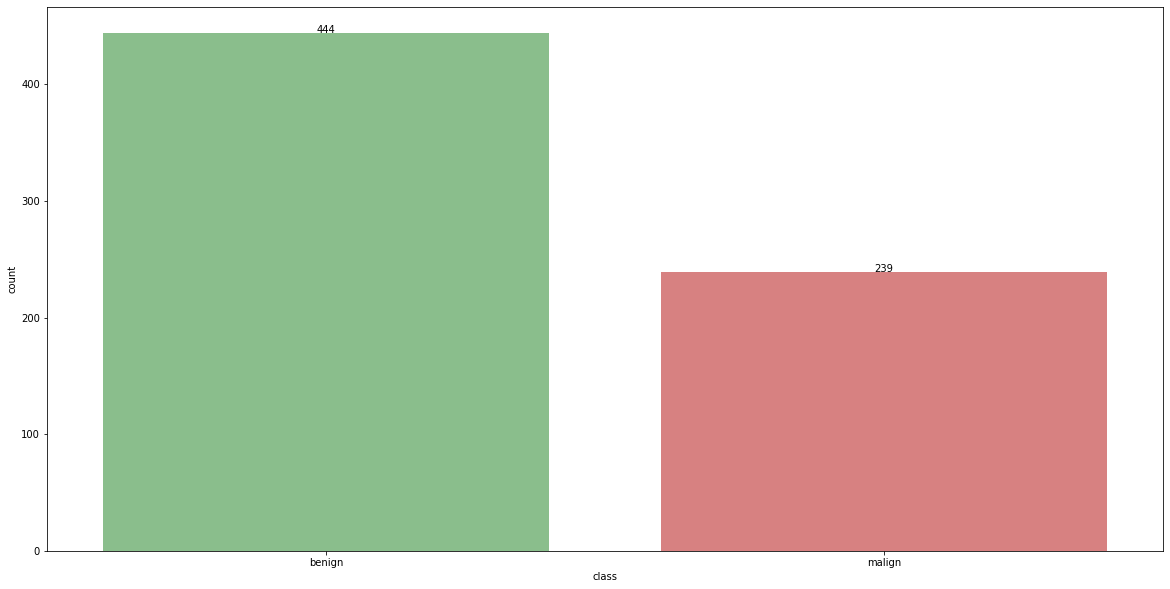

In [16]:
fig, ax1 = plt.subplots(figsize=(20,10), facecolor = "white")
col_dict = {"benign":"#81c784", "malign": "#e57373"}
graph = sns.countplot(dataset_DF["class"], palette=col_dict);
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center");

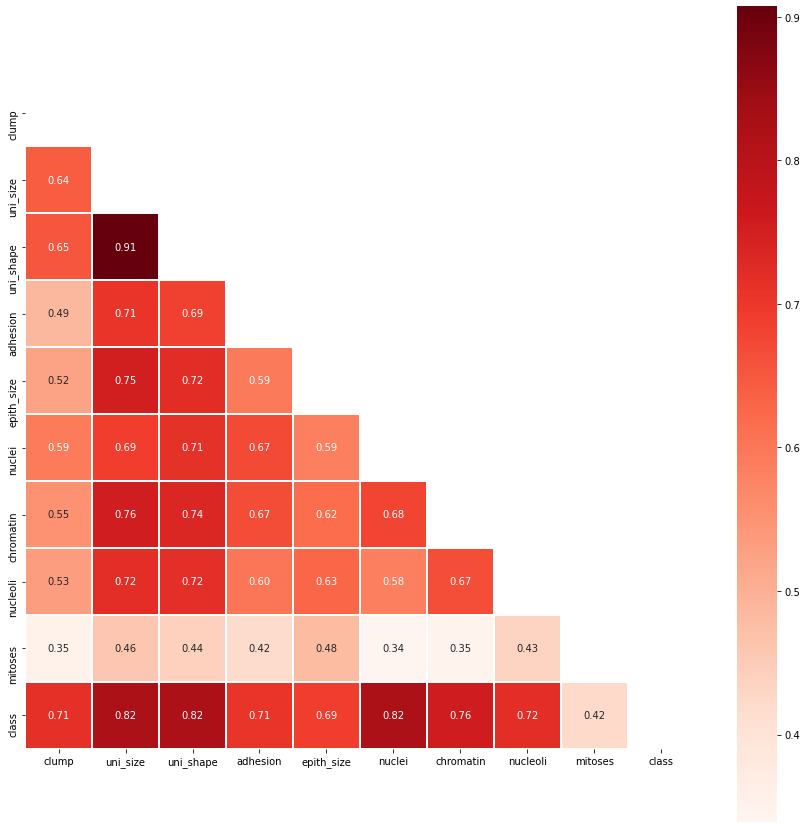

In [17]:
f,ax = plt.subplots(figsize=(15,15), facecolor="white")
mask = np.triu(np.ones_like(encoded.corr(), dtype=bool))
sns.heatmap(encoded.corr(), annot=True, linewidths=0.5, fmt='.2f', cmap='Reds', ax=ax, square=True, mask=mask);

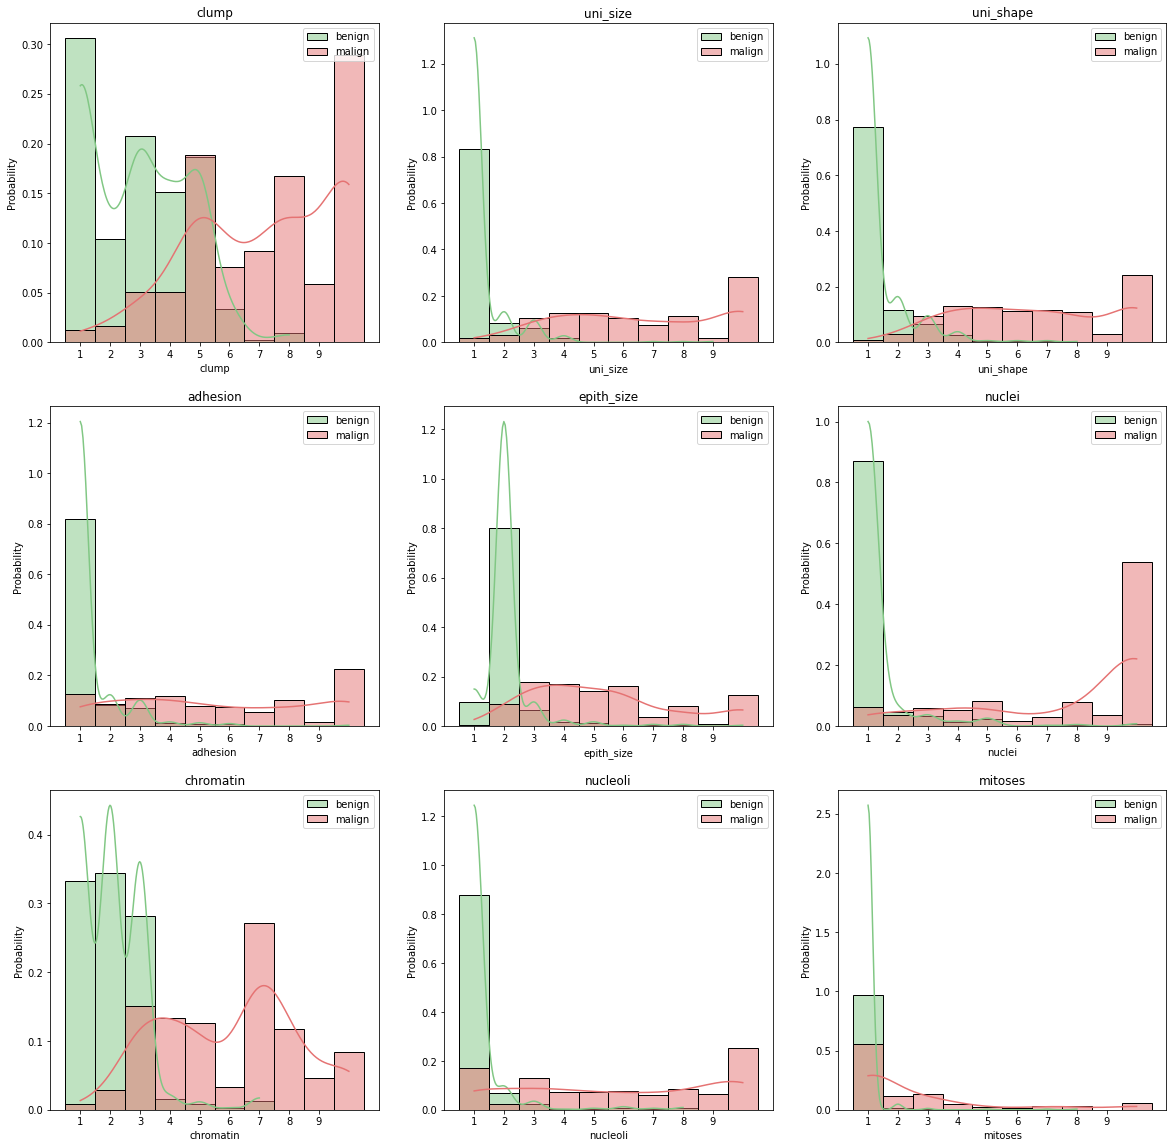

In [18]:
plt.subplots(3, 3, figsize = (20, 20), facecolor = "white")

for i, col in enumerate(dataset_DF.columns[:9]):
  plt.subplot(3, 3, i+1)
  sns.histplot(dataset_DF.loc[dataset_DF['class'] == 'benign', col], stat="probability", label='benign', color="#81c784", element="bars", discrete=True, kde=True)
  sns.histplot(dataset_DF.loc[dataset_DF['class'] == 'malign', col], stat="probability", label='malign', color="#e57373", element="bars", discrete=True, kde=True)
  plt.title(col)
  plt.xticks(np.arange(1,10,1))
  plt.legend(loc='upper right')

In [19]:
if viz:
  plt.subplots(3, 3, figsize = (20, 20), facecolor = "white")
  for i, col in enumerate(dataset_DF.columns[:9]):
    plt.subplot(3, 3, i+1)
    sns.swarmplot(y=dataset_DF.iloc[:, i] , x="class", size=2, palette=col_dict, data=dataset_DF);
    plt.xlabel("Type of Cancer", size=14)

In [20]:
if viz:
  sns.set_style("ticks")
  sns.pairplot(dataset_DF, hue = "class", diag_kind="kde", height=2, palette=col_dict)

# Processing

In [21]:
#splitting data and target dataframe
x = dataset_DF.reset_index(drop=True)
x_unscaled = x
seed = 42
x_unscaled

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,benign
1,5,4,4,5,7,10,3,2,1,benign
2,3,1,1,1,2,2,3,1,1,benign
3,6,8,8,1,3,4,3,7,1,benign
4,4,1,1,3,2,1,3,1,1,benign
...,...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,2,1,1,1,benign
679,2,1,1,1,2,1,1,1,1,benign
680,5,10,10,3,7,3,8,10,2,malign
681,4,8,6,4,3,4,10,6,1,malign


In [22]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.iloc[:, :9])
x_scaled

array([[ 0.19790469, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.26278299, ..., -0.18182716,
        -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       ...,
       [ 0.19790469,  2.23617957,  2.2718962 , ...,  1.86073779,
         2.33747554,  0.22916583],
       [-0.15686934,  1.58320366,  0.93248739, ...,  2.67776377,
         1.02618536, -0.34839971],
       [-0.15686934,  1.58320366,  1.6021918 , ...,  2.67776377,
         0.37054027, -0.34839971]])

In [23]:
scaled_DF = pd.DataFrame(data=x_scaled, columns=['clump', 'uni_size', 'uni_shape',	'adhesion',	'epith_size',	'nuclei',	'chromatin', 'nucleoli',	'mitoses'])
scaled_DF_with_labels = pd.concat((scaled_DF ,(dataset_DF.iloc[:, 9].reset_index(drop=True))), axis=1)

In [24]:
scaled_DF

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses
0,0.197905,-0.702212,-0.741774,-0.639366,-0.555608,-0.698853,-0.181827,-0.612927,-0.348400
1,0.197905,0.277252,0.262783,0.758032,1.695166,1.772867,-0.181827,-0.285105,-0.348400
2,-0.511643,-0.702212,-0.741774,-0.639366,-0.555608,-0.424217,-0.181827,-0.612927,-0.348400
3,0.552679,1.583204,1.602192,-0.639366,-0.105454,0.125054,-0.181827,1.354008,-0.348400
4,-0.156869,-0.702212,-0.741774,0.059333,-0.555608,-0.698853,-0.181827,-0.612927,-0.348400
...,...,...,...,...,...,...,...,...,...
678,-0.511643,-0.702212,-0.741774,-0.639366,-0.105454,-0.424217,-0.998853,-0.612927,-0.348400
679,-0.866417,-0.702212,-0.741774,-0.639366,-0.555608,-0.698853,-0.998853,-0.612927,-0.348400
680,0.197905,2.236180,2.271896,0.059333,1.695166,-0.149582,1.860738,2.337476,0.229166
681,-0.156869,1.583204,0.932487,0.408682,-0.105454,0.125054,2.677764,1.026185,-0.348400


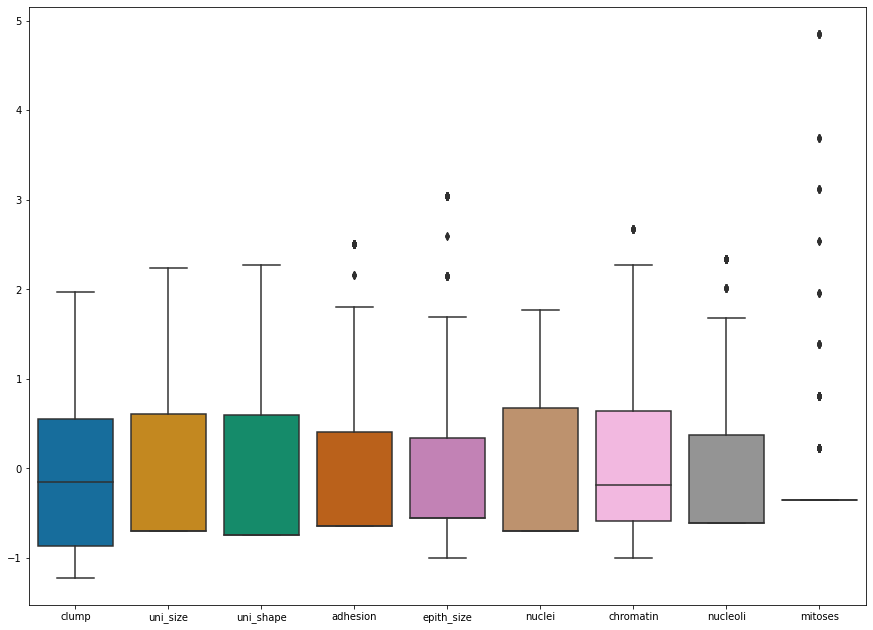

In [25]:
plt.figure(figsize=(15,11))
ax = sns.boxplot(data=scaled_DF_with_labels, palette='colorblind')

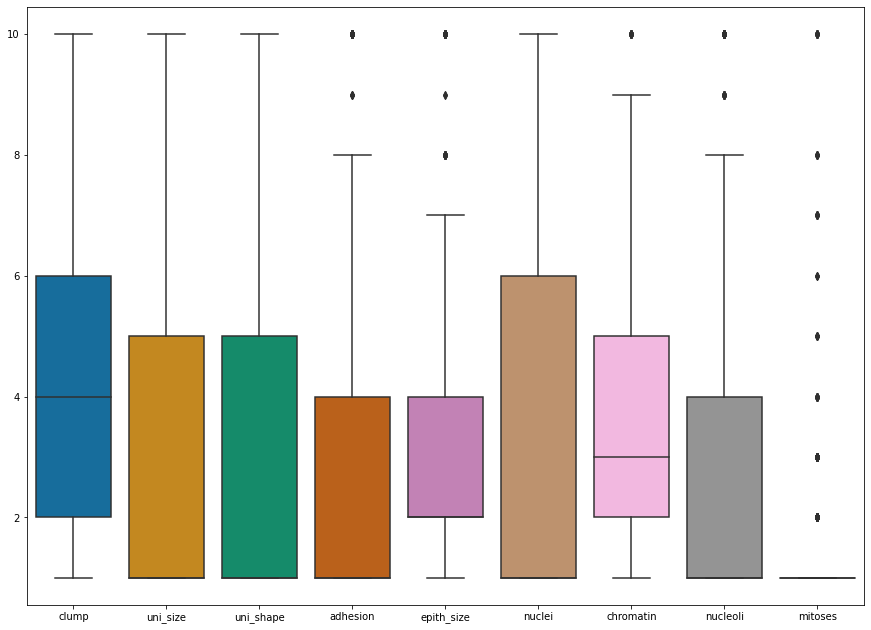

In [26]:
plt.figure(figsize=(15,11))
ax = sns.boxplot(data=x_unscaled, palette='colorblind')

In [27]:
x = scaled_DF_with_labels.iloc[:, :9]
y = scaled_DF_with_labels.iloc[:, 9].replace("benign", 0).replace("malign", 1)

[0.65549993 0.74171625 0.80163316 0.85270288 0.89495575 0.92849758
 0.96120899 0.99017964 1.        ]


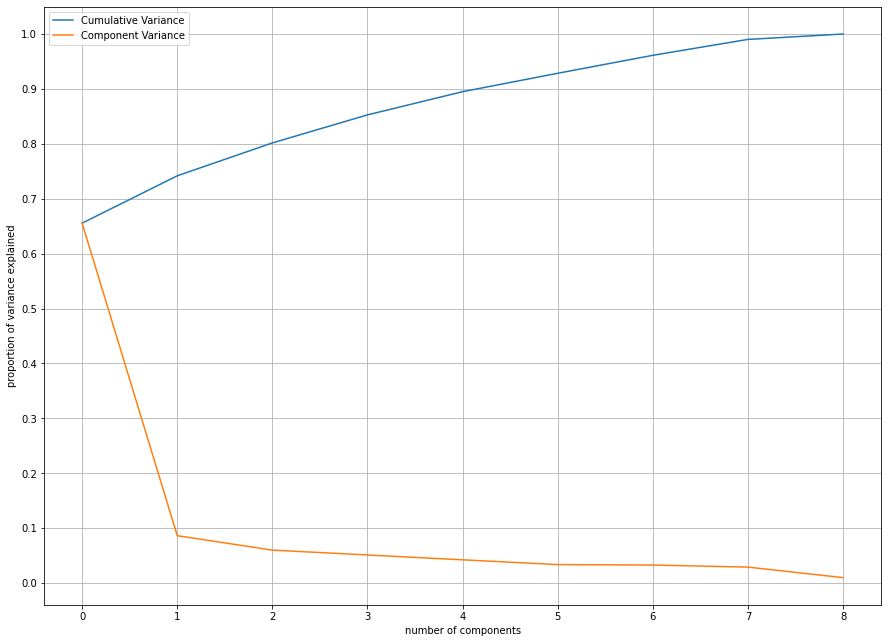

In [28]:

from sklearn.decomposition import PCA

pca = PCA(random_state=SEED).fit(x)
plt.figure(figsize=(15,11))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('proportion of variance explained');
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.legend(['Cumulative Variance', 'Component Variance'])
print(np.cumsum(pca.explained_variance_ratio_))


In [29]:
pca = PCA(n_components = 5)
x_pca = pca.fit_transform(x)

In [30]:
x_pca_DF = pd.DataFrame(data=x_pca)
x_pca_DF

,0,1,2,3,4
0,-1.470171,-0.104273,-0.565685,-0.031959,-0.150998
1,1.442046,-0.570141,0.236601,-0.478150,1.643085
2,-1.592478,-0.076120,0.048858,-0.092388,-0.059739
3,1.479812,-0.528452,-0.603048,1.410827,-0.560737
4,-1.344862,-0.090719,0.029997,-0.338284,-0.108829
...,...,...,...,...,...
678,-1.723605,0.184232,-0.085730,0.110661,0.412880
679,-2.074148,0.231929,0.182329,0.093465,0.120498
680,3.789261,-0.142209,0.662144,2.496133,-0.443185
681,2.240007,-1.091287,1.031890,0.678641,-0.980591


In [31]:
#without pca performances are worsened bc
#The PCA is a change of variables, using the correlations explained by orthogonal directions.
#Removing directions with non-representative corresponding correlation is like removing noise. You will only keep significant data.

# Classification

In [32]:
X_train_val, X_test, y_train_val, y_test = train_test_split(x_pca, y, test_size=0.30, random_state=SEED,stratify=y)

In [33]:
final_report = {'LoRe': [], 'DTree': [], 'RF': [], 'KNN': [], 'SVM': []}

##Logistic Regression
---

In [34]:
#To avoid overfitting we use KFold Stratified (stratidication given class imbalance)
# Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. 
# In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.

kf = StratifiedKFold(n_splits=10, shuffle=True)

# StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
    

    #Classification
    loRe = LogisticRegression(solver='newton-cg', multi_class='ovr', C=50)
    loRe.fit(X_train, y_train)
    pred = loRe.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

mean score 0.9636038961038962


Accuracy = 0.9609756097560975
F1 = 0.9452054794520548
Precision = 0.9583333333333334
Recall = 0.9324324324324325


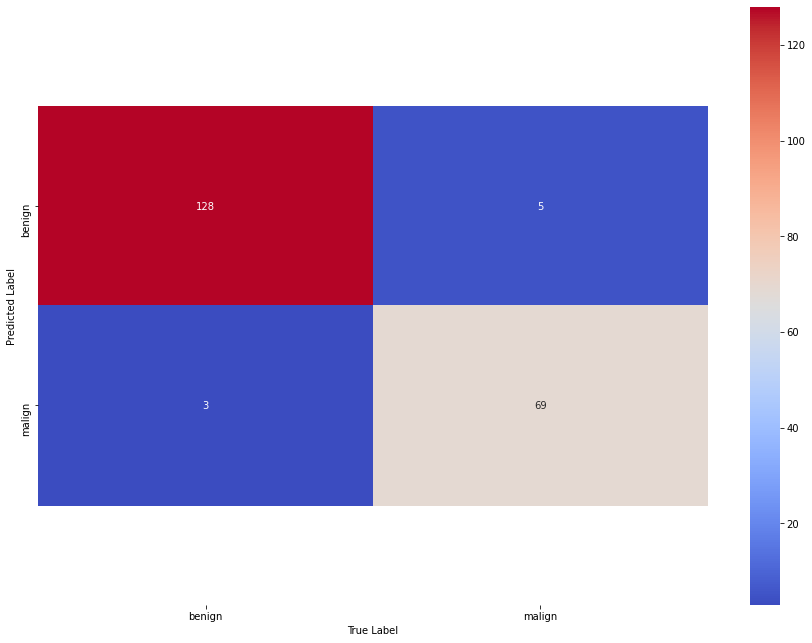

In [35]:
# results on the test set
loRe = LogisticRegression(solver='newton-cg', multi_class='ovr', C=50)
loRe.fit(X_train_val, y_train_val)
pred = loRe.predict(X_test)
final_report['LoRe'].append(accuracy_score(pred,y_test))
print(f"Accuracy = {accuracy_score(pred,y_test)}")
final_report['LoRe'].append(f1_score(pred,y_test))
print(f"F1 = {f1_score(pred,y_test)}")
final_report['LoRe'].append(precision_score(pred,y_test))
print(f"Precision = {precision_score(pred,y_test)}")
final_report['LoRe'].append(recall_score(pred,y_test))
print(f"Recall = {recall_score(pred,y_test)}")
plt.figure(figsize=(15,11))
confmat(y_test,pred)

Decision Tree CLF
---

In [36]:
kf = StratifiedKFold(n_splits=10, shuffle=True)

# StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
    
    #Classification
    dTree = DecisionTreeClassifier()
    dTree.fit(X_train, y_train)
    pred = dTree.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

mean score 0.9550264196587726


Accuracy = 0.9658536585365853
F1 = 0.9523809523809524
Precision = 0.9722222222222222
Recall = 0.9333333333333333


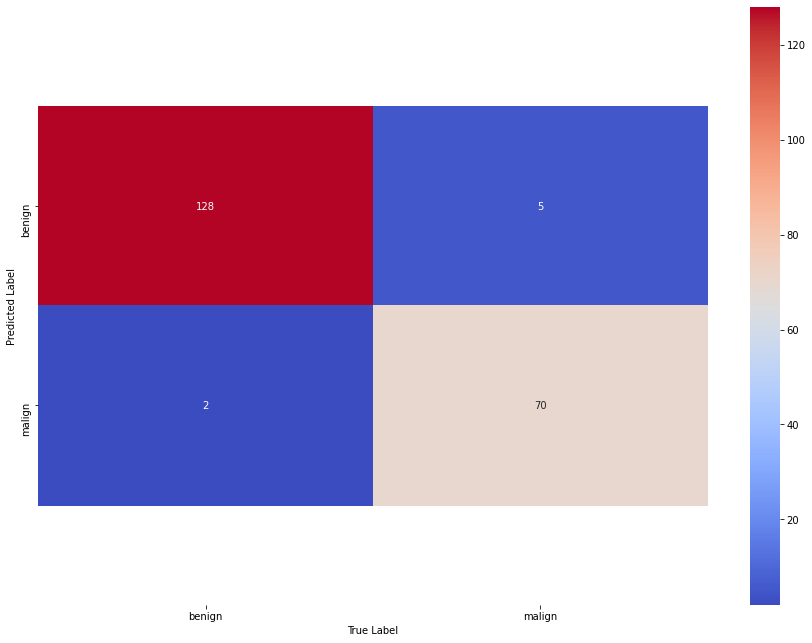

In [37]:
# results on the test set
dTree = DecisionTreeClassifier()
dTree.fit(X_train_val, y_train_val)
pred = dTree.predict(X_test)
final_report['DTree'].append(accuracy_score(pred,y_test))
print(f"Accuracy = {accuracy_score(pred,y_test)}")
final_report['DTree'].append(f1_score(pred,y_test))
print(f"F1 = {f1_score(pred,y_test)}")
final_report['DTree'].append(precision_score(pred,y_test))
print(f"Precision = {precision_score(pred,y_test)}")
final_report['DTree'].append(recall_score(pred,y_test))
print(f"Recall = {recall_score(pred,y_test)}")
plt.figure(figsize=(15,11))
confmat(y_test, pred)

Random Forest CLF
---

In [38]:
if tune:
  #List Hyperparameters that we want to tune.
  estimators_list = [50, 70, 90, 100, 110, 130, 140]
  features_list = ["log2", "sqrt", "auto"]
  sample_leafs_list = [2, 4, 8, 10]
  #Convert to dictionary
  hyperparameters = dict(n_estimators=estimators_list, max_features=features_list, min_samples_leaf = sample_leafs_list)
  #Create new KNN object
  rfc = RandomForestClassifier()
  #Use GridSearch
  clf = GridSearchCV(rfc, hyperparameters, cv=10, n_jobs=-1, scoring = scoring)
  #Fit the model
  best_model = clf.fit(x_pca,y)
  #Print The value of best Hyperparameters
  print('Best estimator:', best_model.best_estimator_.get_params()['n_estimators'])
  print('Best feature:', best_model.best_estimator_.get_params()['max_features'])
  print('Best sample leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])

In [39]:
#To avoid overfitting we use KFold Stratified (stratidication given class imbalance)
# Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. 
# In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.

kf = StratifiedKFold(n_splits=10, shuffle=True)

# StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]

    #Classification
    clf = RandomForestClassifier(n_estimators = 70, min_samples_leaf = 4, max_features='log2', random_state = 42)
    if tune:
      clf = RandomForestClassifier(n_estimators = best_model.best_estimator_.get_params()['n_estimators'], min_samples_leaf = best_model.best_estimator_.get_params()['min_samples_leaf'], max_features=best_model.best_estimator_.get_params()['max_features'], random_state = 42)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

mean score 0.957000103869299


Accuracy = 0.9707317073170731
F1 = 0.9594594594594595
Precision = 0.9861111111111112
Recall = 0.9342105263157895


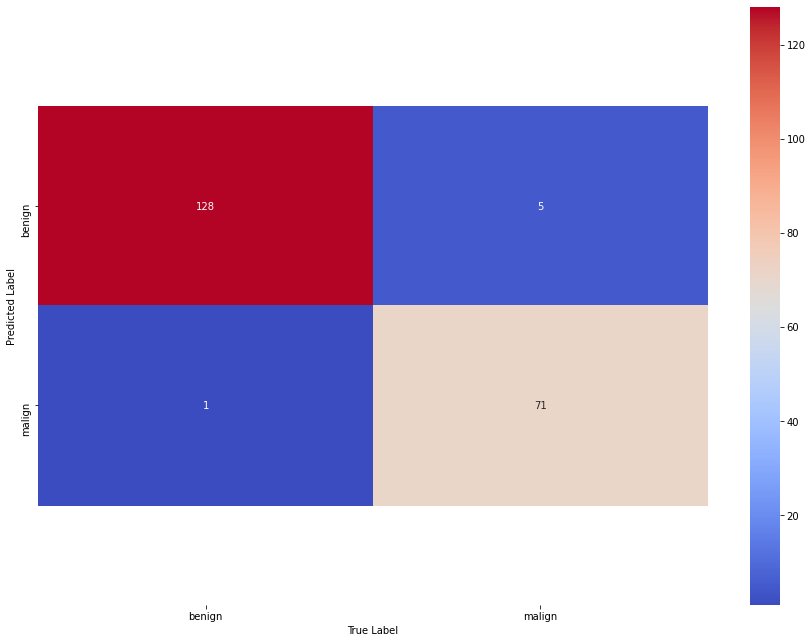

In [40]:
# results on the test set
clf = RandomForestClassifier(n_estimators = 70, min_samples_leaf = 4, max_features='log2', random_state = 42)
if tune:
  clf = RandomForestClassifier(n_estimators = best_model.best_estimator_.get_params()['n_estimators'], min_samples_leaf = best_model.best_estimator_.get_params()['min_samples_leaf'], max_features=best_model.best_estimator_.get_params()['max_features'], random_state = 42)
clf.fit(X_train_val, y_train_val)
pred = clf.predict(X_test)
final_report['RF'].append(accuracy_score(pred,y_test))
print(f"Accuracy = {accuracy_score(pred,y_test)}")
final_report['RF'].append(f1_score(pred,y_test))
print(f"F1 = {f1_score(pred,y_test)}")
final_report['RF'].append(precision_score(pred,y_test))
print(f"Precision = {precision_score(pred,y_test)}")
final_report['RF'].append(recall_score(pred,y_test))
print(f"Recall = {recall_score(pred,y_test)}")
plt.figure(figsize=(15,11))
confmat(y_test, pred)

KNeighbors CLF
---

In [41]:
if tune:
  #List Hyperparameters that we want to tune.
  leaf_size = list(range(1,50))
  n_neighbors = list(range(1,30))
  algorithm_list = ['auto', 'ball_tree', 'kd_tree', 'brute']
  p=[1,2]
  #Convert to dictionary
  hyperparameters = dict(leaf_size=leaf_size, algorithm = algorithm_list, n_neighbors=n_neighbors, p=p)
  #Create new KNN object
  knn = KNeighborsClassifier()
  #Use GridSearch
  clf = GridSearchCV(knn, hyperparameters, cv=10, n_jobs=-1, scoring= scoring)
  #Fit the model
  best_model = clf.fit(x_pca,y)
  #Print The value of best Hyperparameters
  print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
  print('Best p:', best_model.best_estimator_.get_params()['p'])
  print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

In [42]:
#To avoid overfitting we use KFold Stratified (stratidication given class imbalance)
# Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. 
# In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.

kf = StratifiedKFold(n_splits=10, shuffle=True)

# StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
    
    #Classification
    knn = KNeighborsClassifier(leaf_size=1, p=2, n_neighbors=5)
    if tune:
      knn = KNeighborsClassifier(leaf_size=best_model.best_estimator_.get_params()['leaf_size'], p=best_model.best_estimator_.get_params()['p'], n_neighbors=best_model.best_estimator_.get_params()['n_neighbors'])
    
    knn.fit(X_train, y_train)
    pred = knn.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

mean score 0.9643016297428062


Accuracy = 0.9609756097560975
F1 = 0.9452054794520548
Precision = 0.9583333333333334
Recall = 0.9324324324324325


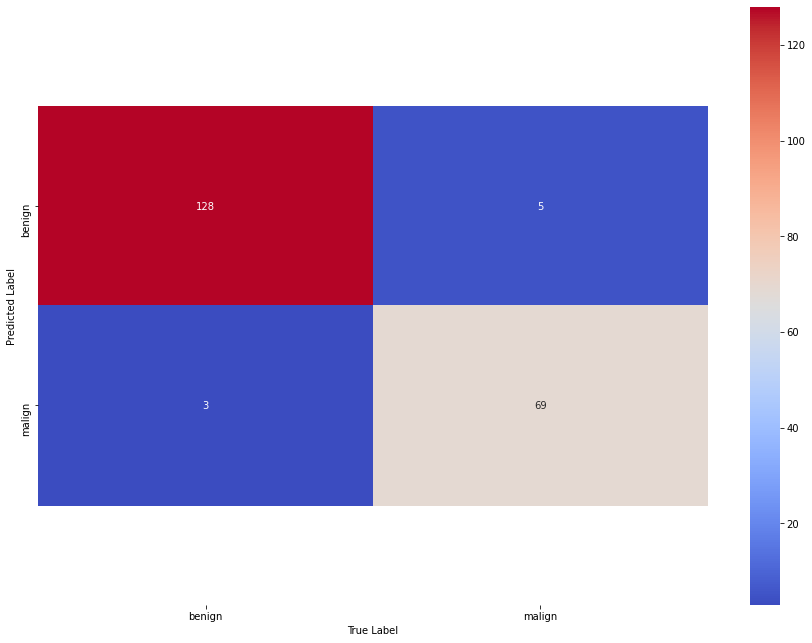

In [43]:
# results on the test set
knn = KNeighborsClassifier(leaf_size=1, p=2, n_neighbors=5)
if tune:
  knn = KNeighborsClassifier(leaf_size=best_model.best_estimator_.get_params()['leaf_size'], p=best_model.best_estimator_.get_params()['p'], n_neighbors=best_model.best_estimator_.get_params()['n_neighbors'])

knn.fit(X_train_val, y_train_val)
pred = knn.predict(X_test)
final_report['KNN'].append(accuracy_score(pred,y_test))
print(f"Accuracy = {accuracy_score(pred,y_test)}")
final_report['KNN'].append(f1_score(pred,y_test))
print(f"F1 = {f1_score(pred,y_test)}")
final_report['KNN'].append(precision_score(pred,y_test))
print(f"Precision = {precision_score(pred,y_test)}")
final_report['KNN'].append(recall_score(pred,y_test))
print(f"Recall = {recall_score(pred,y_test)}")
plt.figure(figsize=(15,11))
confmat(y_test, pred)

Support Vector Machine CLF
---

In [44]:
if (tune):
  #List Hyperparameters that we want to tune.
  C_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
  G_list = [0.0001,0.001,0.005,0.01,0.05,0.1,0.5,1,10,100,1000]
  kernel_list = ['rbf', 'sigmoid','linear']
  #Convert to dictionary
  hyperparameters = dict(C=C_list, gamma=G_list, kernel = kernel_list)
  #Create new KNN object
  svc_CLF = SVC()
  #Use GridSearch
  clf = GridSearchCV(svc_CLF, hyperparameters, cv=10, n_jobs=-1, scoring = scoring)
  #Fit the model
  best_model = clf.fit(x_pca,y)
  #Print The value of best Hyperparameters
  print('Best C:', best_model.best_estimator_.get_params()['C'])
  print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
  print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])

In [45]:
#To avoid overfitting we use KFold Stratified (stratidication given class imbalance)
# Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. 
# In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.

kf = StratifiedKFold(n_splits=10, shuffle=True)

# StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
    
    #Classification
    clf = SVC(C=10, gamma=0.1, kernel='rbf')
    if tune:
      clf = SVC(C=best_model.best_estimator_.get_params()['C'], gamma=best_model.best_estimator_.get_params()['gamma'], kernel=best_model.best_estimator_.get_params()['kernel'])
    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

mean score 0.9524411086460421


Accuracy = 0.9609756097560975
F1 = 0.9452054794520548
Precision = 0.9583333333333334
Recall = 0.9324324324324325


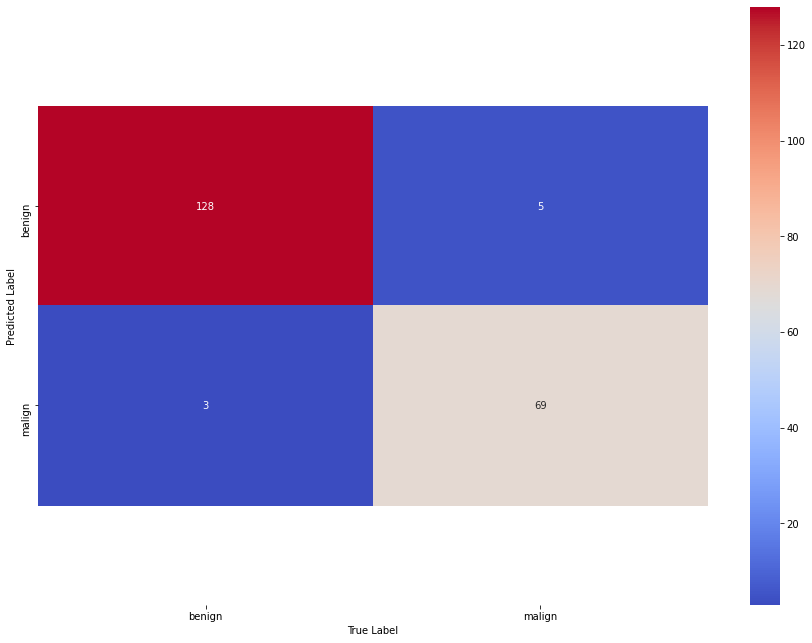

In [46]:
# results on the test set
clf = SVC(C=10, gamma=0.1, kernel='rbf')
if tune:
  clf = SVC(C=best_model.best_estimator_.get_params()['C'], gamma=best_model.best_estimator_.get_params()['gamma'], kernel=best_model.best_estimator_.get_params()['kernel'])

clf.fit(X_train_val, y_train_val)
pred = clf.predict(X_test)
final_report['SVM'].append(accuracy_score(pred,y_test))
print(f"Accuracy = {accuracy_score(pred,y_test)}")
final_report['SVM'].append(f1_score(pred,y_test))
print(f"F1 = {f1_score(pred,y_test)}")
final_report['SVM'].append(precision_score(pred,y_test))
print(f"Precision = {precision_score(pred,y_test)}")
final_report['SVM'].append(recall_score(pred,y_test))
print(f"Recall = {recall_score(pred,y_test)}")
plt.figure(figsize=(15,11))
confmat(y_test, pred)

# Final Report

In [47]:
final_report

{'DTree': [0.9658536585365853,
  0.9523809523809524,
  0.9722222222222222,
  0.9333333333333333],
 'KNN': [0.9609756097560975,
  0.9452054794520548,
  0.9583333333333334,
  0.9324324324324325],
 'LoRe': [0.9609756097560975,
  0.9452054794520548,
  0.9583333333333334,
  0.9324324324324325],
 'RF': [0.9707317073170731,
  0.9594594594594595,
  0.9861111111111112,
  0.9342105263157895],
 'SVM': [0.9609756097560975,
  0.9452054794520548,
  0.9583333333333334,
  0.9324324324324325]}

In [48]:
accuracies = []
f1s = []
precisions = []
recalls = []
models = []
for el in final_report.keys():
  models.append(el)
  accuracies.append(final_report[el][0])
  f1s.append(final_report[el][1])
  precisions.append(final_report[el][2])
  recalls.append(final_report[el][3])

In [49]:
scores = pd.DataFrame(list(zip(accuracies, f1s, precisions,recalls)), 
               columns =['accuracy', 'f1', 'precision','recall'], index = models)
scores

,accuracy,f1,precision,recall
LoRe,0.960976,0.945205,0.958333,0.932432
DTree,0.965854,0.952381,0.972222,0.933333
RF,0.970732,0.959459,0.986111,0.934211
KNN,0.960976,0.945205,0.958333,0.932432
SVM,0.960976,0.945205,0.958333,0.932432


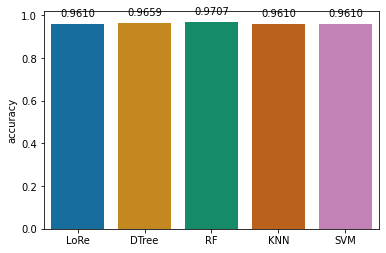

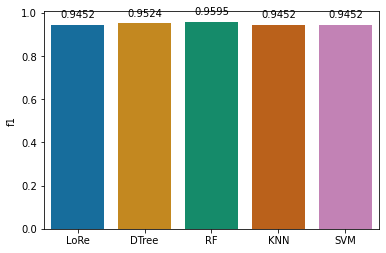

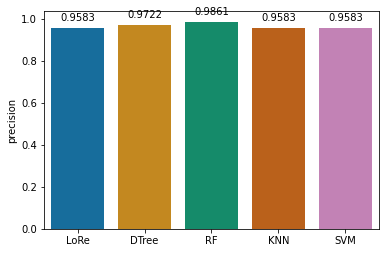

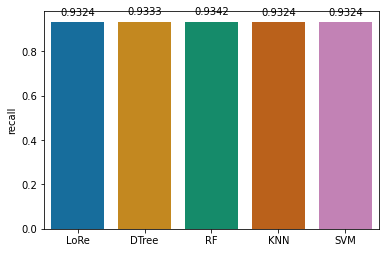

In [50]:
for i in ['accuracy', 'f1', 'precision','recall']:
  ax = sns.barplot(x=models,y=scores[i],palette='colorblind')
  for p in ax.patches:
    ax.annotate("{:.4f}".format(p.get_height(), 'f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
  plt.show()